# DSC 210 Project: Linear Algebra in Image Compression

## Evaluation metric
- PSNR
- MS-SSIM
- Bit Rate

In [1]:
import torch
from torchvision import transforms

def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

def compute_msssim(a, b):
    return ms_ssim(a, b, data_range=1.).item()

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

## Image Datasets

- [Kodak](https://www.kaggle.com/datasets/sherylmehta/kodak-dataset)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


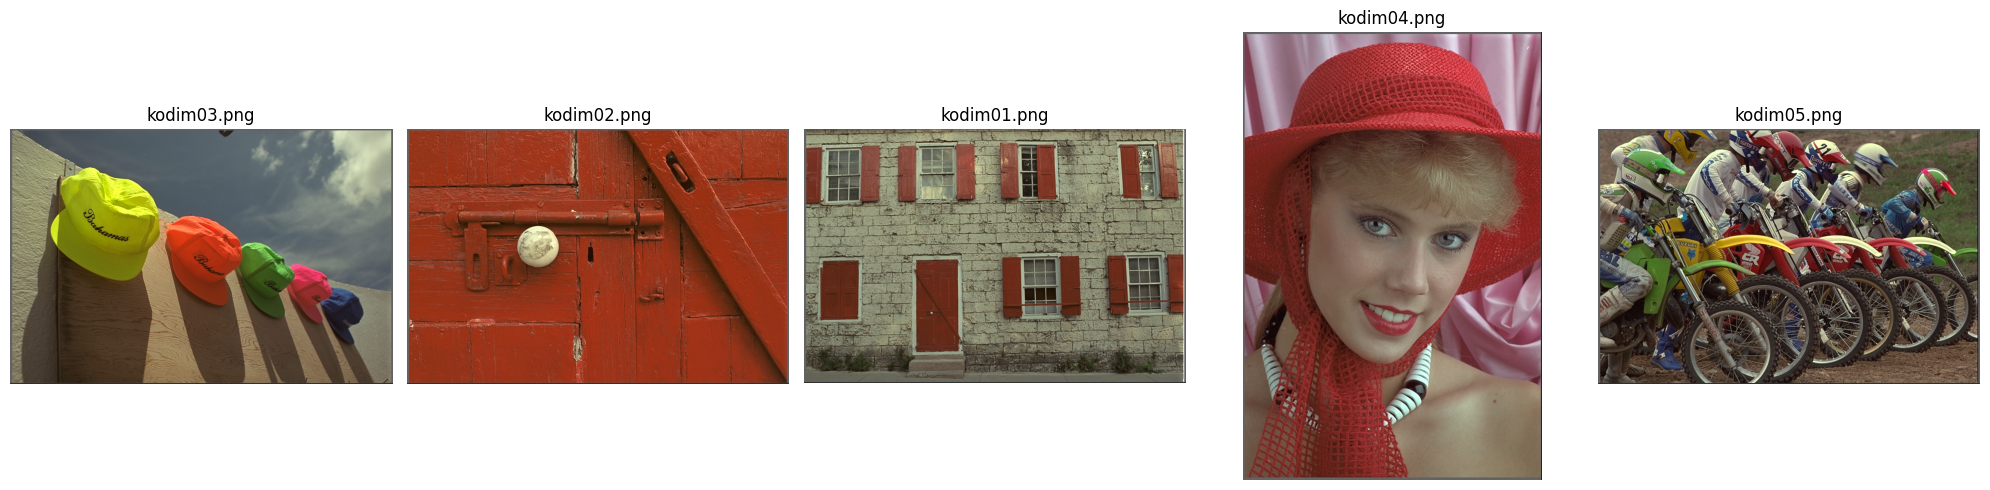

In [5]:
import os
import matplotlib.pyplot as plt
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')

def show_images(image_folder, num_images=5):
  # Get a list of image files in the directory
  image_files = [f for f in os.listdir(image_folder)]
  selected_images = image_files[:num_images]

  # Set up the matplotlib figure and subplots
  fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

  # Loop through the selected images and display them
  for ax, image_file in zip(axes, selected_images):
      # Open and load the image
      img_path = os.path.join(image_folder, image_file)
      img = Image.open(img_path)

      # Display the image
      ax.imshow(img)
      ax.axis('off')  # Hide the axes

      # Set the title as the image file name
      ax.set_title(image_file)

  # Adjust layout
  plt.tight_layout()
  plt.show()

# Specify the directory containing the images
image_folder_kodak = '/content/drive/MyDrive/Kodak'
show_images(image_folder_kodak)

[Tecnick](https://sourceforge.net/projects/testimages/files/OLD/OLD_SAMPLING/testimages.zip)

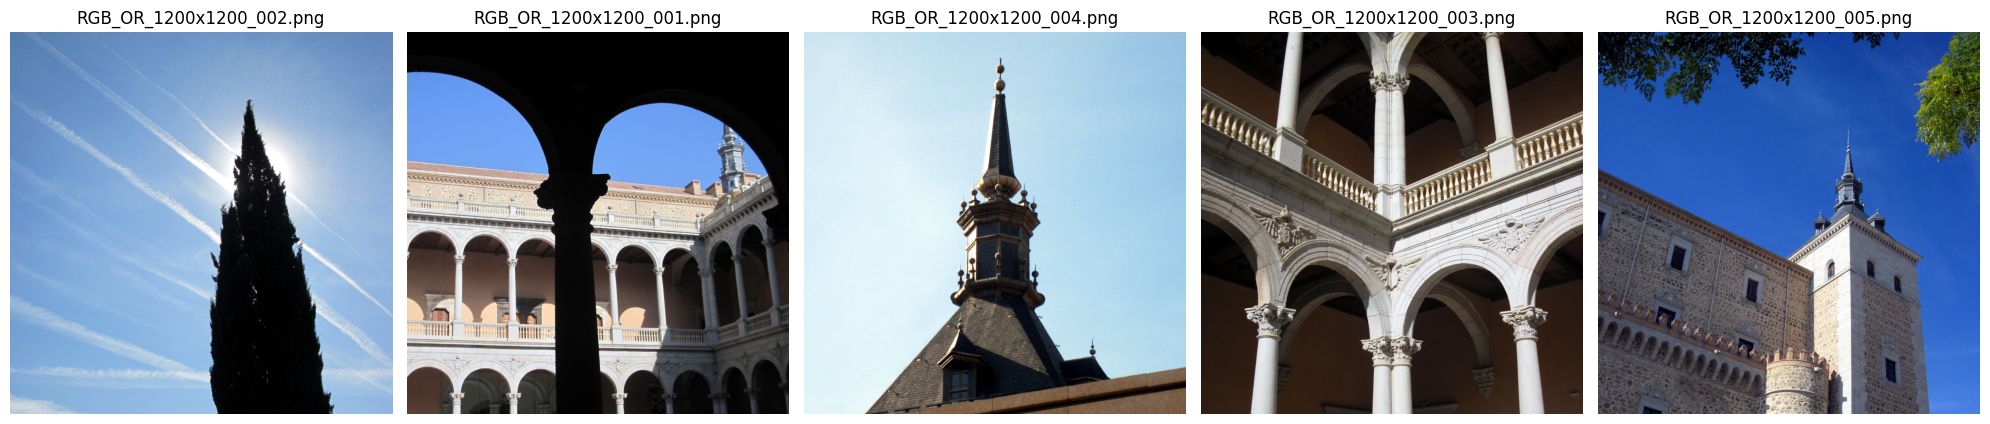

In [6]:
# Specify the directory containing the images
image_folder_tecnick = '/content/drive/MyDrive/Tecnick'
show_images(image_folder_tecnick)

## Linear Algebra Implementation

### **TODO:**

## State-of Art Algorithms

### Algorithm
Based on the article [Variational Image Compression with a Scale Hyperprior](https://arxiv.org/abs/1802.01436) and the article [Joint Autoregressive and Hierarchical Priors for Learned Image Compression](https://arxiv.org/abs/1809.02736).

**Import Libraries:**

In [10]:
!pip install pytorch-msssim
!pip install compressai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.6 MB/s eta 0:00:00
  Created wheel for compressai: filename=compressai-1.2.6-cp310-cp310-linux_x86_64.whl size=405684 sha256=0c16eadae5fbe26ad8a4f8f28b0c2e1f77ec0eb2aeda89ae8fee7e3da8431967
  Stored in directory: /root/.cache/pip/wheels/b3/e1/85/87edc5d40a531877f35ba1cfc8f66e2e76d49d4845f57c0f46
Successfully built compressai


In [11]:
import torch
from pytorch_msssim import ms_ssim
from torchvision import transforms
import numpy as np
import math
import os
from PIL import Image
import matplotlib.pyplot as plt
from compressai.zoo import bmshj2018_factorized, mbt2018_mean

/usr/local/lib/python3.10/dist-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)


**Import Pertained Models:**

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
bmshjmodel = bmshj2018_factorized(quality=1, metric='mse', pretrained=True, progress=True)
mbtmodel = mbt2018_mean(quality=1, metric="mse", pretrained=True, progress=True)

Downloading: "https://compressai.s3.amazonaws.com/models/v1/bmshj2018-factorized-prior-1-446d5c7f.pth.tar" to /root/.cache/torch/hub/checkpoints/bmshj2018-factorized-prior-1-446d5c7f.pth.tar
100%|██████████| 11.5M/11.5M [00:00<00:00, 29.7MB/s]
Downloading: "https://compressai.s3.amazonaws.com/models/v1/mbt2018-mean-1-e522738d.pth.tar" to /root/.cache/torch/hub/checkpoints/mbt2018-mean-1-e522738d.pth.tar
100%|██████████| 27.6M/27.6M [00:00<00:00, 33.5MB/s]


In [13]:
# Specify the directory containing the images
image_folder_kodak = '/content/drive/MyDrive/Kodak'
# Get a list of image files in the directory
image_files_kodak = [f for f in os.listdir(image_folder_kodak)]

x_hat_list_bmshj = []
rec_img_list_bmshj = []
diff_list_bmshj = []
x_hat_list_mbt = []
rec_img_list_mbt = []
diff_list_mbt = []

psnr_list_bmshj = []
ssim_list_bmshj = []
bpp_list_bmshj = []
psnr_list_mbt = []
ssim_list_mbt = []
bpp_list_mbt = []

for img in image_files_kodak:
    img_path = os.path.join(image_folder_kodak, img)
    img = Image.open(img_path).convert("RGB")
    # calculate recustructed x
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out_net = bmshjmodel.forward(x)
    out_net['x_hat'].clamp_(0, 1)
    x_hat_list_bmshj.append(out_net['x_hat'])
    # calculate metrics
    psnr_list_bmshj.append(compute_psnr(x, out_net['x_hat']))
    ssim_list_bmshj.append(compute_msssim(x, out_net['x_hat']))
    bpp_list_bmshj.append(compute_bpp(out_net))
    # convert x into image
    rec_img = transforms.ToPILImage()(out_net['x_hat'].squeeze().cpu())
    rec_img_list_bmshj.append(rec_img)
    # calculate difference
    diff = torch.mean((out_net['x_hat'] - x).abs(), axis=1).squeeze().cpu()
    diff_list_bmshj.append(diff)

for img in image_files_kodak:
    img_path = os.path.join(image_folder_kodak, img)
    img = Image.open(img_path).convert("RGB")
    # calculate recustructed x
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out_net = mbtmodel.forward(x)
    out_net['x_hat'].clamp_(0, 1)
    x_hat_list_mbt.append(out_net['x_hat'])
    # calculate metrics
    psnr_list_mbt.append(compute_psnr(x, out_net['x_hat']))
    ssim_list_mbt.append(compute_msssim(x, out_net['x_hat']))
    bpp_list_mbt.append(compute_bpp(out_net))
    # convert x into image
    rec_img = transforms.ToPILImage()(out_net['x_hat'].squeeze().cpu())
    rec_img_list_mbt.append(rec_img)
    # calculate difference
    diff = torch.mean((out_net['x_hat'] - x).abs(), axis=1).squeeze().cpu()
    diff_list_mbt.append(diff)

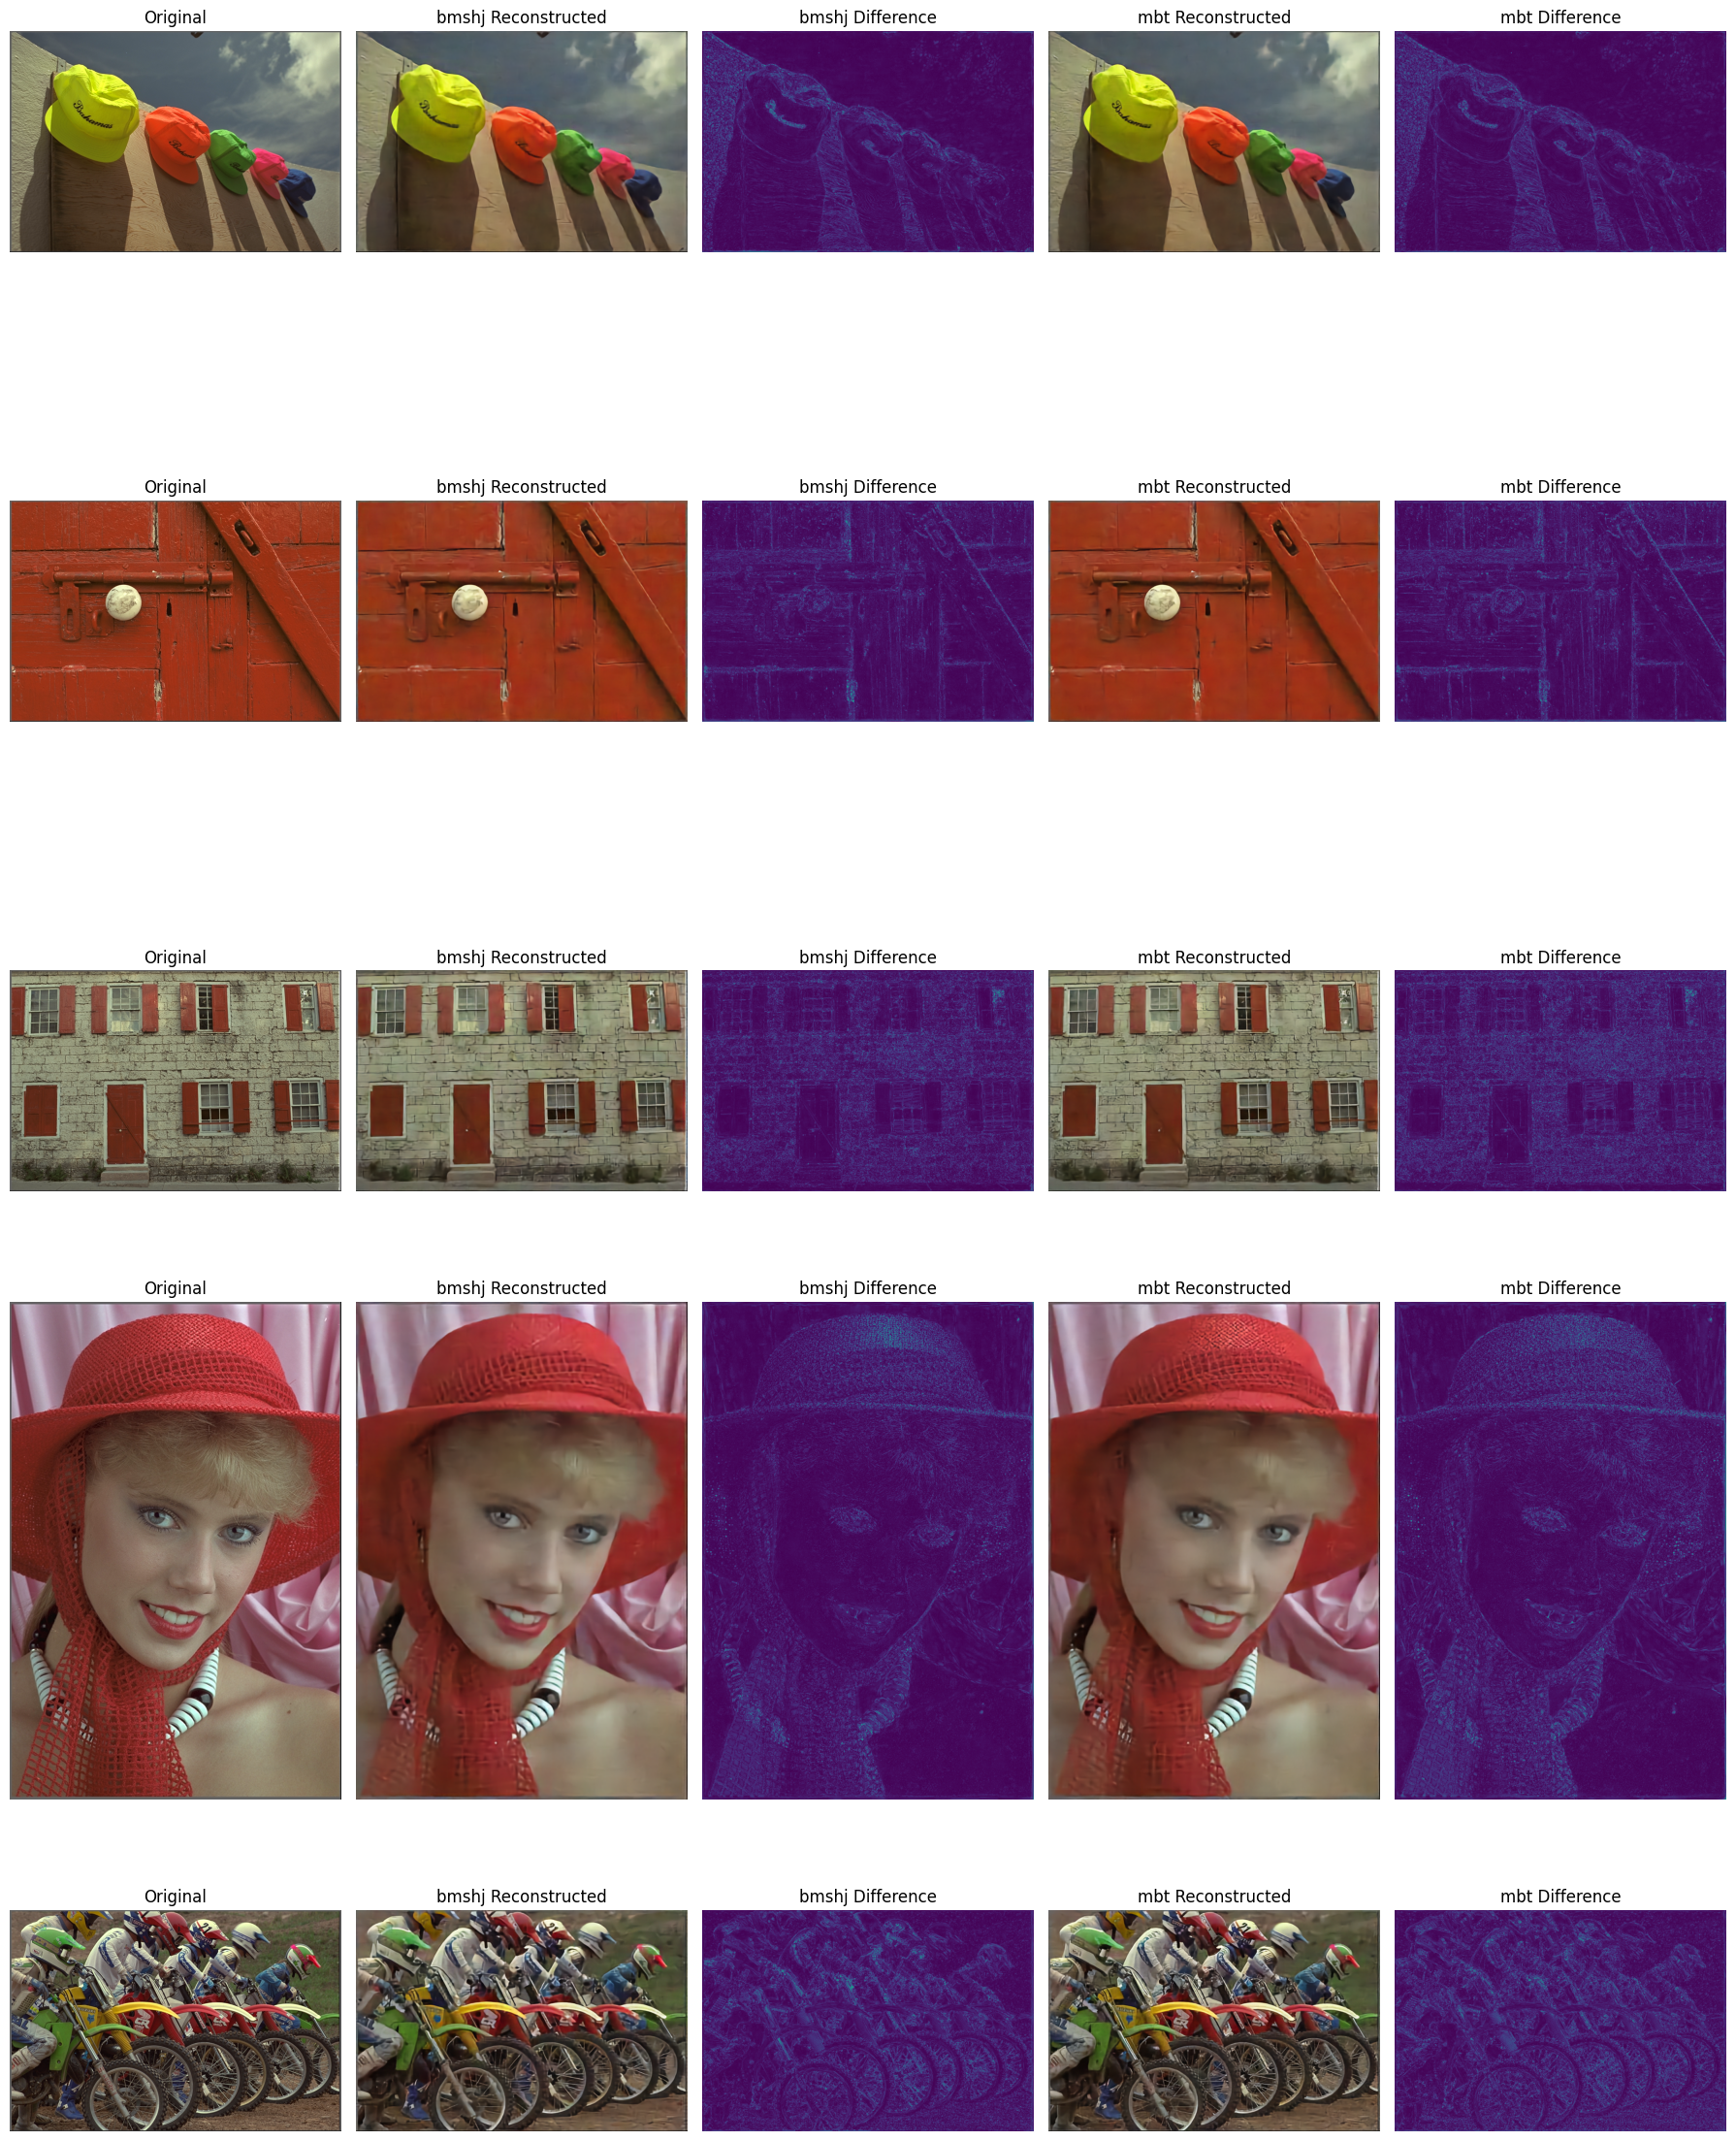

In [15]:
# Get a list of image files in the directory
image_files = [f for f in os.listdir(image_folder_kodak)]
selected_images_bmsh = image_files[:5]
reconstructed_images_bmshj = rec_img_list_bmshj[:5]
diff_images_bmshj = diff_list_bmshj[:5]

reconstructed_images_mbt = rec_img_list_mbt[:5]
diff_images_mbt = diff_list_mbt[:5]

# Set up the overall figure
fig, axes = plt.subplots(5, 5, figsize=(18, 25))

for i in range(5):
    # Hide axes for all subplots
    for ax in axes[i]:
        ax.axis('off')

    # Original image
    img_path = os.path.join(image_folder_kodak, selected_images_bmsh[i])
    img = Image.open(img_path)
    axes[i, 0].imshow(img)
    axes[i, 0].title.set_text('Original')

    # Reconstructed image
    axes[i, 1].imshow(reconstructed_images_bmshj[i])
    axes[i, 1].title.set_text('bmshj Reconstructed')

    # Difference image
    axes[i, 2].imshow(diff_images_bmshj[i], cmap='viridis')
    axes[i, 2].title.set_text('bmshj Difference')

    # Reconstructed image
    axes[i, 3].imshow(reconstructed_images_mbt[i])
    axes[i, 3].title.set_text('mbt Reconstructed')

    # Difference image
    axes[i, 4].imshow(diff_images_mbt[i], cmap='viridis')
    axes[i, 4].title.set_text('mbt Difference')

# Adjust layout
plt.tight_layout()

In [16]:
print(f'bmsh PSNR: {np.mean(psnr_list_bmshj):.4f} dB')
print(f'bmsh MS-SSIM: {np.mean(ssim_list_bmshj):.4f}')
print(f'bmsh Bit-rate: {np.mean(bpp_list_bmshj):.4f} bpp')

print(f'mbt PSNR: {np.mean(psnr_list_mbt):.4f} dB')
print(f'mbt MS-SSIM: {np.mean(ssim_list_mbt):.4f}')
print(f'mbt Bit-rate: {np.mean(bpp_list_mbt):.4f} bpp')

bmsh PSNR: 27.1189 dB
bmsh MS-SSIM: 0.9158
bmsh Bit-rate: 0.1337 bpp
mbt PSNR: 28.2316 dB
mbt MS-SSIM: 0.9256
mbt Bit-rate: 0.2450 bpp
